In [215]:
from fredapi import Fred
import pandas_datareader as pdr
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nasdaqdatalink
import ffn
import yfinance as yf
from pandas.plotting import scatter_matrix
import mplfinance as mfp
import talib
import json
from typing import List, Optional, Any, Dict, Tuple, Union
from pandas.tseries.offsets import DateOffset

%matplotlib inline

class UtilsVisuals:

    @staticmethod
    def plot_line_close_and_volume(df: pd.DataFrame, title: str = None):
        mfp.plot(df, type="line", title=("close & volume" if title is None else title), figratio=(30,10), volume=True)
    
    @staticmethod
    def plot_series_line(series: Dict[str, pd.Series], title: str = None, figsize: Tuple[int, int] = None):
        size = ((24,6) if figsize is None else figsize)
        for t, s in series.items():
            s.plot(label=t, title=title, figsize=size)
        plt.legend()
    
    @staticmethod
    def plot_candlesticks_and_volume(df: pd.DataFrame, title: str = None, figratio: Tuple[int, int] = None):
        ratio = ((60,20) if figratio is None else figratio)
        mfp.plot(df, type="candle", title=("price & volume" if title is None else title), figratio=ratio, volume=True, figscale=0.75)

    @staticmethod
    def histogram(data: pd.Series, bins: int = None, figsize: Tuple[int, int] = None, title: str = None, xlabel: str = None, ylabel: str = None):
        size = ((16,8) if figsize is None else figsize)
        if bins is None:
            bins = int(1 + 3.3222 * np.log10(data.size))
        data.hist(bins=bins, figsize=size)
        if title is not None:
            plt.title(title)
        if ylabel is not None:
            plt.ylabel(ylabel)
        if xlabel is not None:
            plt.xlabel(xlabel)
        plt.legend()

    @staticmethod
    def scatter_matrix(df: pd.DataFrame, cols: List[str]):
        scatter_matrix(df[cols])
   
    @staticmethod
    def scatter_plot(df: pd.DataFrame, x: str, y: str, figsize: Tuple[int, int] = None, title: str = None):
        df.plot(kind="scatter", x=x, y=y)
        if title is not None:
            plt.title(title)
        plt.ylabel(y)
        plt.xlabel(x)
        plt.legend()

    @staticmethod
    def box_plot(data: Union[pd.Series, pd.DataFrame], title: str = None, xlabel: str = None, ylabel: str = None):
        data.plot(kind="box", title=title, xlabel=xlabel, ylabel=ylabel)
    
    @staticmethod
    def correlation_heatmap(df: pd.DataFrame, title: str=None):
        df.plot_corr_heatmap(title=title)





class UtilsFinance:

    CONFIG_KEY_SECRETS = "secrets_json_file"
    __DEFAULT_INTERVAL: str = "1d"

    def __init__(self, config: Optional[Dict[str, Any]] = None):
        if self.CONFIG_KEY_SECRETS not in config:
            raise Exception(f"must provide {self.CONFIG_KEY_SECRETS} in config")
        with open(config[self.CONFIG_KEY_SECRETS]) as f:
            self._secrets = json.load(f)
            self._fred = None
    
    def __market_data_as_point(self, market_data, symbols: List[str]) -> pd.DataFrame:

        result = pd.DataFrame(columns=["symbol", "variable", "value", "actual_time"])
        df_as_dict = {"symbol": [], "variable": [], "value": [], "actual_time": []}
        if not market_data.empty:
            multiple_symbols: bool = 1 < len(symbols)
            for key, val in market_data.to_dict().items():
                if multiple_symbols:
                    variable, symbol = key
                else:
                    variable = key
                    symbol = symbols[0]

                for ts, num in val.items():
                    if not pd.isnull(num):
                        (df_as_dict["symbol"]).append(symbol)
                        (df_as_dict["variable"]).append(variable)
                        (df_as_dict["value"]).append(num)
                        (df_as_dict["actual_time"]).append(ts.timestamp())

            result = pd.DataFrame.from_dict(df_as_dict)

        return result

    def __market_data_as_row(self, market_data, symbols: List[str]) -> pd.DataFrame:

        df = self.__market_data_as_point(market_data, symbols)
        df = df.pivot(index=["actual_time", "symbol"], columns='variable', values='value')
        df.columns.name = None
        return df

    def get_ticker(self, key: str, start: datetime=None, end: datetime=None, as_data_point: bool=False, **kwargs) -> pd.DataFrame:

        symbols_as_str = key
        symbols: List[str] = [k.strip() for k in symbols_as_str.split(",")]

        interval = self.__DEFAULT_INTERVAL
        if "interval" in kwargs:
            interval = kwargs["interval"]

        market_data = yf.download(symbols_as_str, start=start, end=end, interval=interval)
        if as_data_point:
            result = self.__market_data_as_point(market_data, symbols)
            result.reset_index(drop=True, inplace=True)
        else:
            result = self.__market_data_as_row(market_data, symbols)
            result.reset_index(drop=False, inplace=True)
        
        result['ts'] = pd.to_datetime(result['actual_time'],unit='s')
        result.set_index("ts", inplace=True)
        result.sort_index(ascending=True, inplace=True)

        result = result.rename(columns={"Adj Close": "adj_close", "Close": "close", "High": "high", "Low": "low", "Open": "open", "Volume": "volume"})

        return result

    @property
    def fred(self):
        if self._fred is None:
            self._fred = Fred(api_key=self._secrets["FRED_KEY"])
        return self._fred
    
    def get_us_realGdp(self) -> pd.DataFrame:
        return pdr.DataReader("GDPC1", "fred")
    
    def get_maket_cap(self, ticker: str) -> float:
        return yf.Ticker(ticker).info["marketCap"]
    
    def get_covariance_matrix(self, df: pd.DataFrame, cols: List[str]):
        return df[cols].cov()
    
    def get_us_cpi_all_items(self) -> pd.Series:
        return self.fred.get_series("USACPALTT01CTGYM").sort_index(ascending=False)
    
    def get_us_t10_yield(self) -> pd.Series:
        return self.fred.get_series("DGS10").sort_index(ascending=False)
    
    def get_risk_free_rate(self) -> pd.DataFrame:

        df_t10 = pd.DataFrame(o.get_us_t10_yield(), columns=["t10"])
        df_t10["on_month"] = df_t10.index.strftime("%Y%m").astype("int")
        df_t10 = df_t10.reset_index()

        df_cpi = pd.DataFrame(o.get_us_cpi_all_items(), columns=["cpi"])
        df_cpi.reset_index(inplace=True)
        # consider last month cpi as we don't have it today, only at eom
        df_cpi["index"] = df_cpi["index"] + DateOffset(months=1)
        df_cpi.set_index(["index"], inplace=True)
        df_cpi["on_month"] = df_cpi.index.strftime("%Y%m").astype("int")
        df_cpi.reset_index(drop=True, inplace=True)

        df = pd.merge(df_t10, df_cpi, on="on_month" , how="left")
        df.set_index(["index"], inplace=True)
        df.drop(["on_month"], inplace=True, axis=1)
        
        return df
    

o = UtilsFinance({"secrets_json_file": "../.secrets.json"})

In [113]:
df = o.get_ticker("AMD")
df2 = o.get_ticker("NVDA")
df_all = pd.concat([df["close"].pct_change(), df2["close"].pct_change()], axis=1).dropna()
df_all.columns = ["amd", "nvda"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [216]:
o.get_risk_free_rate()

,t10,cpi
index,,
2024-01-25,4.14,3.262937
2024-01-24,4.18,3.262937
2024-01-23,4.14,3.262937
2024-01-22,4.11,3.262937
2024-01-19,4.15,3.262937
...,...,...
1962-01-08,4.03,NaN
1962-01-05,4.02,NaN
1962-01-04,3.99,NaN


In [168]:
o.get_us_t10_yield()

2024-01-25    4.14
2024-01-24    4.18
2024-01-23    4.14
2024-01-22    4.11
2024-01-19    4.15
              ... 
1962-01-08    4.03
1962-01-05    4.02
1962-01-04    3.99
1962-01-03    4.03
1962-01-02    4.06
Length: 16193, dtype: float64

In [122]:
o.get_us_cpi_all_items()

2023-12-01    3.262937
2023-11-01    3.121570
2023-10-01    3.214305
2023-09-01    3.650365
2023-08-01    3.696583
                ...   
2010-05-01    0.026482
2010-04-01   -0.001069
2010-03-01   -0.054216
2010-02-01   -0.120399
2010-01-01   -0.160617
Length: 168, dtype: float64

In [118]:
o.get_covariance_matrix(df_all, ["amd", "nvda"])

,amd,nvda
amd,0.001540,0.000708
nvda,0.000708,0.001438


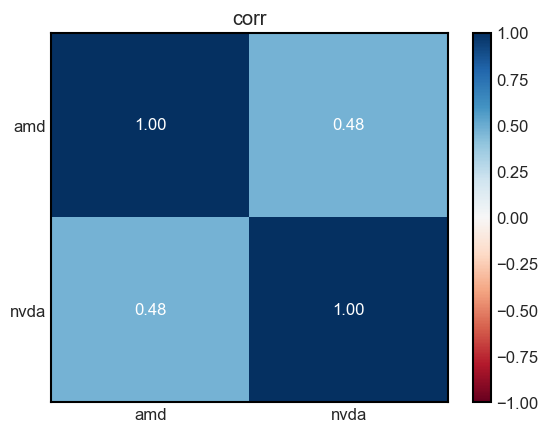

In [112]:
UtilsVisuals.correlation_heatmap(df_all, title="corr")

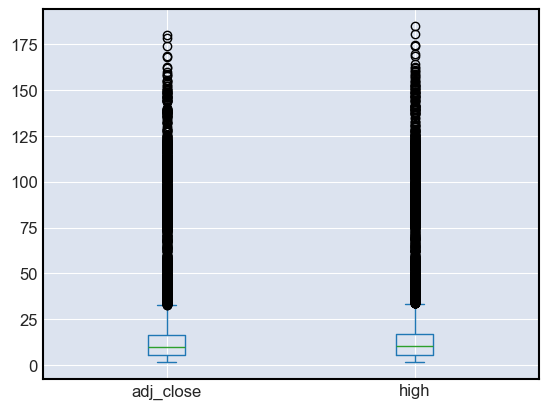

In [102]:
UtilsVisuals.box_plot(df[["adj_close", "high"]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


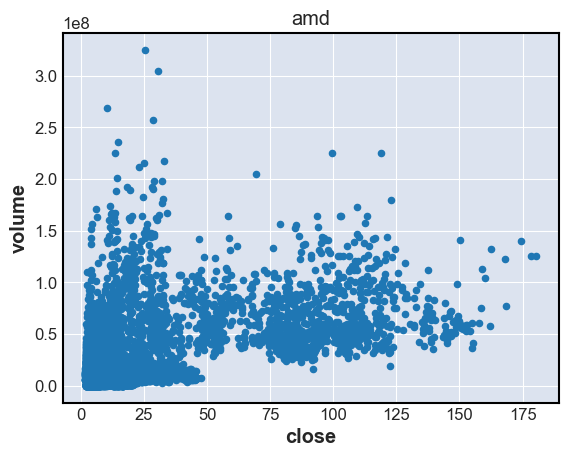

In [92]:
UtilsVisuals.scatter_plot(df, "close", "volume", title="amd")

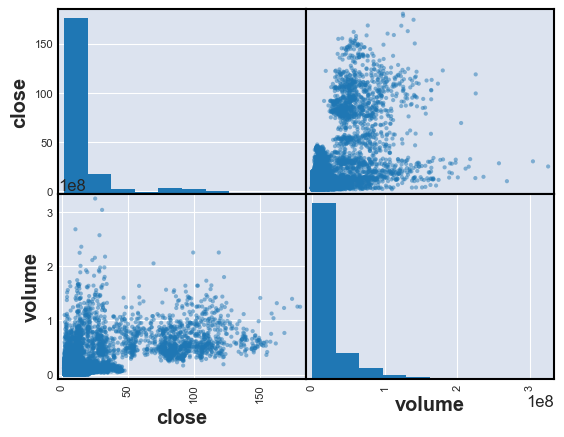

In [93]:
UtilsVisuals.scatter_matrix(df, ["close", "volume"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


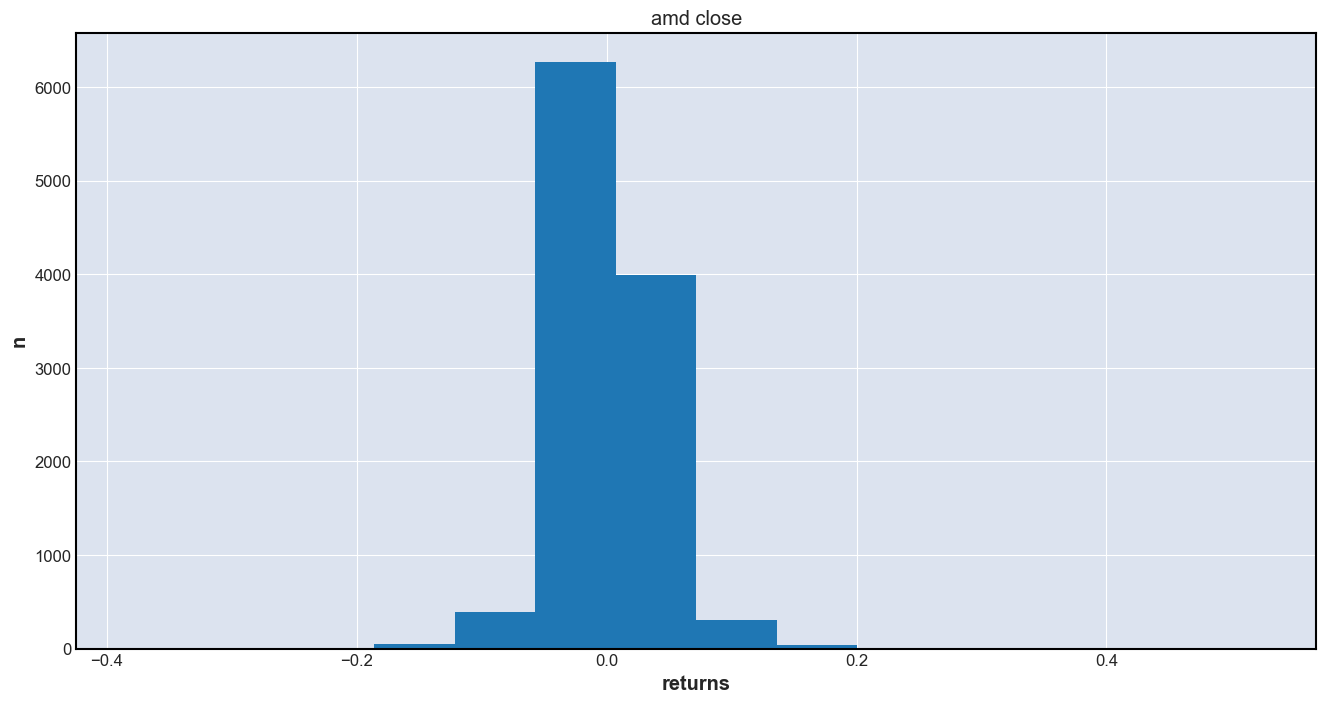

In [94]:
UtilsVisuals.histogram(df["adj_close"].pct_change(), title="amd close", xlabel="returns", ylabel="n")

[*********************100%%**********************]  1 of 1 completed

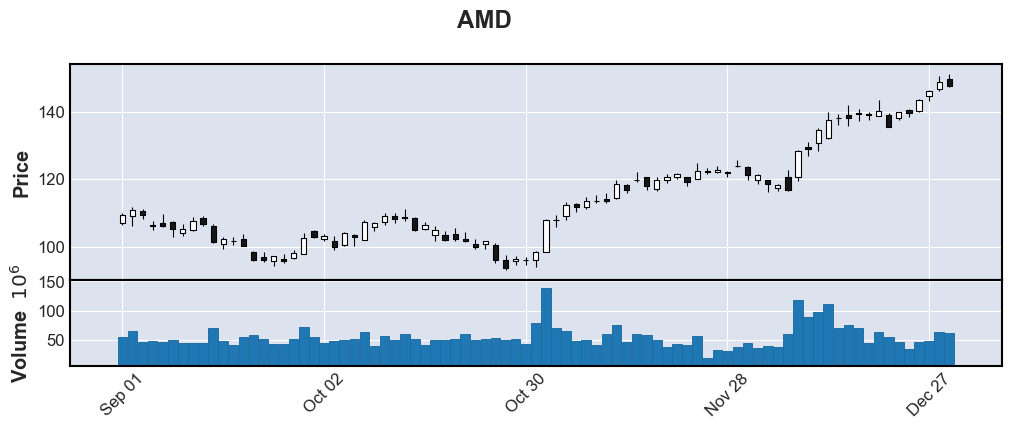

In [95]:
UtilsVisuals.plot_candlesticks_and_volume(o.get_ticker("AMD", start=datetime(2023,9,1), end=datetime(2023,12,31)), title="AMD")

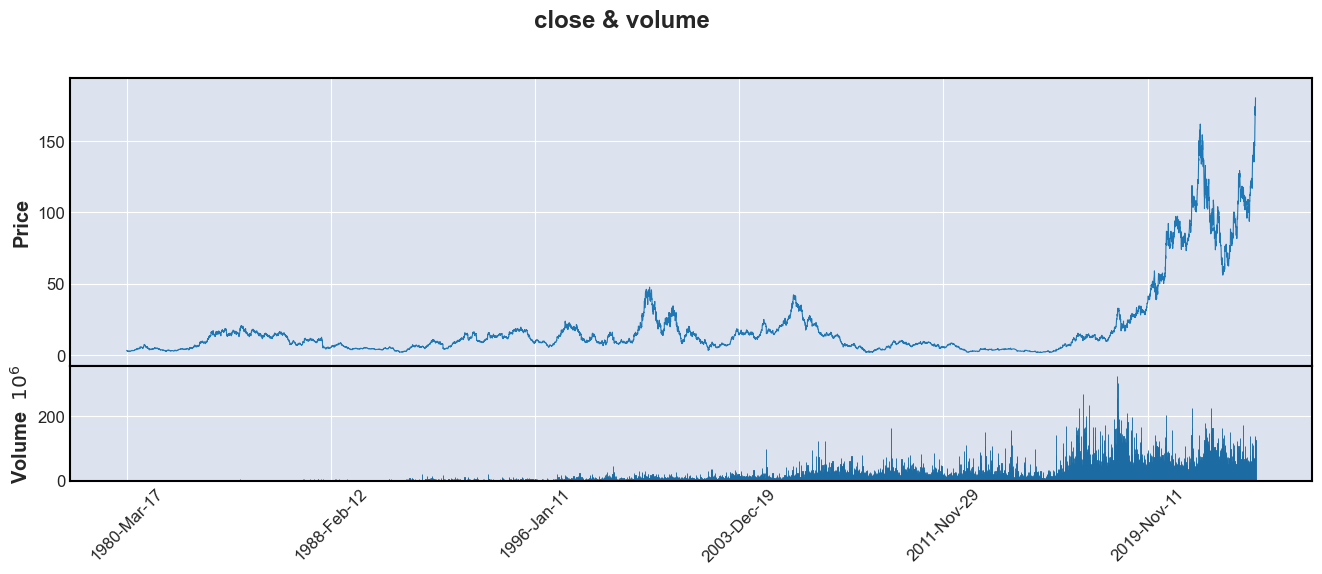

In [96]:
UtilsVisuals.plot_line_close_and_volume(df)

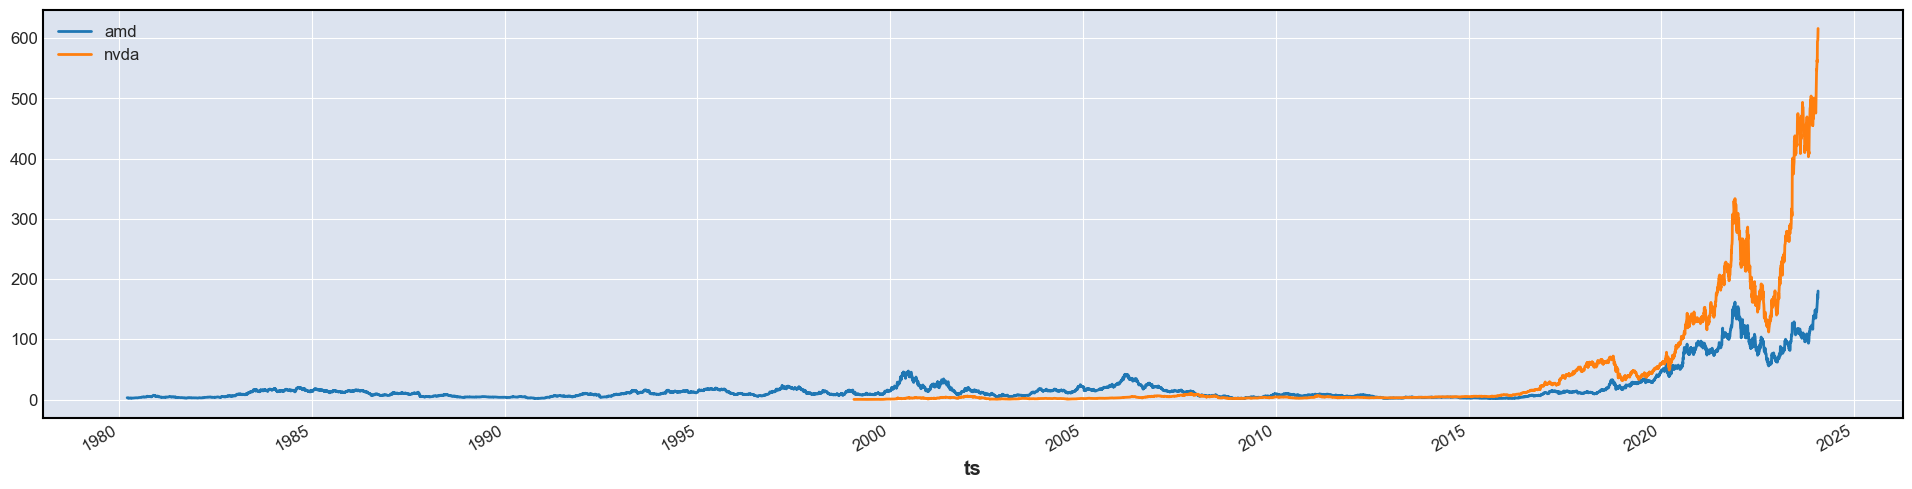

In [97]:
UtilsVisuals.plot_series_line(series={"amd": df["close"], "nvda": df2["close"]})